In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../peptidome.mplstyle')
#plt.style.use('talk')

import sys
sys.path.append('..')

from lib import *

In [2]:
def nndist_probability(k, N):
    K = 20**k
    d = np.arange(0, k+1)
    Nc = lambda d: 19**d * falling_factorial(k, d+1)
    Ncs = Nc(d)
    cumulative = [0]
    cumulative.extend(1-np.exp(-np.cumsum(Ncs)*N/K))
    p = np.diff(cumulative)
    return d, p

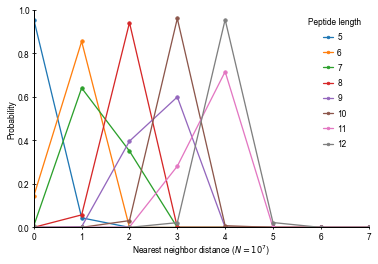

In [3]:
fig, ax = plt.subplots()
N = 1e7
for k in range(5, 13):
    d, p = nndist_probability(k, N)
    ax.plot(d, p, '-o', label=k)
ax.set_ylim(0, 1)
ax.legend(title='Peptide length')
ax.set_xlim(0, 7)
ax.set_ylabel('Probability')
ax.set_xlabel('Nearest neighbor distance ($N=10^{ %g }$)'%np.log10(N))
fig.savefig('main.png')

# Neighbor density

## correlation between probabilities

In [230]:
#S = 20
#k = 10
#sigma = 0.3
#pi = np.random.lognormal(sigma=sigma, size=S)
#pi /= pi.sum()
psigmas = []
psigmaps = []
Nsample = 10000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    i = np.random.randint(0, k)
    sigmai = np.random.choice([s for s in range(0, S) if s != sigma[i]])
    sigmap = np.asarray(list(sigma[:i]) + [sigmai] + list(sigma[i+1:]))
    psigmap = np.prod(pi[sigmap])
    psigmas.append(psigma)
    psigmaps.append(psigmap)
psigmaps = np.asarray(psigmaps)
psigmas = np.asarray(psigmas)

Text(0, 0.5, "$\\log_{10} p(\\sigma')$")

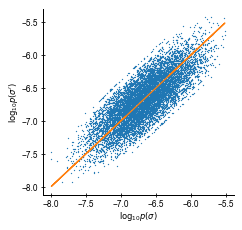

In [231]:
fig, ax = plt.subplots(figsize=(3.42, 3.42))
trans = np.log10
ax.plot(trans(psigmas), trans(psigmaps), '.', label='data', ms=1)
ax.plot(trans(psigmas), trans(psigmas), '-', label='linear')
#psigmas_theory = np.linspace(0.5*S**(-k), 2*S**(-k))
#ax.plot(np.log10(psigmas_theory), np.log10(psigmas_theory)+np.log10(k*(S-1)-S*(psigmas_theory*S**k-1)),
#        '-', label='theory')
#ax.plot([-k*np.log10(S)], [-k*np.log10(S) + np.log10(k*(S-1))], 'o')
ax.set_xlabel('$\log_{10} p(\sigma)$')
ax.set_ylabel("$\log_{10} p(\sigma')$")

In [232]:
rhop = np.corrcoef(psigmaps, psigmas)[0, 1]
rhop, np.corrcoef(np.log(psigmaps), np.log(psigmas))[0, 1]

(0.7228500573175963, 0.7873257391978061)

## check summation formula

In [217]:
def neighbors(sigma, S):
    for i in range(len(sigma)):
        for s in range(S):
            if not sigma[i] == s:
                yield np.asarray(list(sigma[:i]) + [s] + list(sigma[i+1:]))

S = 2
k = 2
sigma_lognormal = 1.0
pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
pi /= pi.sum()
sigma = np.random.randint(0, S, k)
nsigma = np.prod(pi[sigma])*(np.sum(1/pi[sigma]) - k)
nsigma_sum = np.sum(np.fromiter((np.prod(pi[sigmap]) for sigmap in neighbors(sigma, S)), np.float))
print(nsigma, nsigma_sum)

0.49393356157461615 0.49393356157461615


In [52]:
df = Counter(human, 1).to_df(norm=True, clean=True)
paa = np.asarray(df['freq'])
paa

array([0.02132759, 0.06577845, 0.07012693, 0.06314819, 0.09970845,
       0.08332527, 0.01217275, 0.05643573, 0.05963846, 0.07101057,
       0.02662735, 0.02305051, 0.05347764, 0.0473157 , 0.05724314,
       0.04330068, 0.04767035, 0.02626757, 0.0365297 , 0.03584496])

## generate samples from P_uniform(psigma, nsigma)

In [234]:
S = 20
k = 5

Nn = k*(S-1)
N = float(S**k)

sigma_lognormal = 0.4
pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
#pi = paa
#pi = np.random.uniform(size=S)
pi /= pi.sum()


psigmas = []
nsigmas = []
Nsample = 100000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    nsigma = np.prod(pi[sigma])*np.sum((1-pi[sigma])/pi[sigma])
    psigmas.append(psigma)
    nsigmas.append(nsigma)
nsigmas = np.asarray(nsigmas)
psigmas = np.asarray(psigmas)
rho = np.corrcoef(psigmas, nsigmas)[1, 0]
print(r'$\rho_{p(\sigma), n(\sigma)}$:', rho)

$\rho_{p(\sigma), n(\sigma)}$: 0.987328942138644


In [210]:
np.var(np.log(psigmas))/k, np.var(np.log(pi))

(0.2636635698592492, 0.2637393500109682)

In [211]:
sigmasq = np.var(np.log(pi))*k
np.var(psigmas), (np.exp(sigmasq)-1)/N**2

(1.4106820877663723e-23, 3.714200465543339e-23)

slope, prediction 0.8103274592203045 0.7894736842105263
nsigmavar (sampled, upper, pred): 5.252466854628287e-10 9.743341167420795e-10 6.072719564181936e-10 7.071399631293816e-10
nsigmabar (lower, sampled, upper): 2.96875e-05 5.3502812948520496e-05 6.220047437328103e-05
prediction (-S, -3/2S, rhop) 5.5597770140509596e-05 5.214306745510832e-05 5.764723292906861e-05


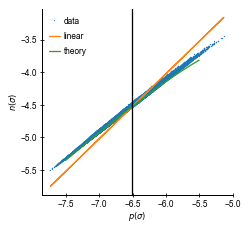

In [235]:
fig, ax = plt.subplots(figsize=(3.42, 3.42))
ax.plot(np.log10(psigmas), np.log10(nsigmas), '.', label='data', ms=1)
ax.plot(np.log10(psigmas), np.log10(psigmas)+np.log10(k*(S-1)), '-', label='linear')
factor = 10
psigmas_theory = np.linspace(S**(-k)/factor, factor*S**(-k))
ax.plot(np.log10(psigmas_theory),
        #np.log10(psigmas_theory) + np.log10(Nn - S*(psigmas_theory*float(S**k) - 1)),
        np.log10(psigmas_theory) + np.log10(Nn - S*np.log(psigmas_theory*N)),
        '-', label='theory')
ax.axvline(-k*np.log10(S), c='k')
ax.set_xlabel('$p(\sigma)$')
ax.set_ylabel('$n(\sigma)$')
ax.legend()
fig.savefig('main_npcorr.png')

slope, intercept = np.polyfit(np.log10(psigmas), np.log10(nsigmas), 1)
rho1 = 1 - S/(k*(S-1))
print('slope, prediction', slope, rho1)
nsigmavar_pred = np.var(psigmas)* Nn**2 * rho1**2
nsigmavar_pred2 = Nn*np.var(psigmas)*(1+(Nn-1)*rhop)
print('nsigmavar (sampled, upper, pred):',
      np.var(nsigmas),
      np.var(psigmas)*Nn**2,
      nsigmavar_pred,
      nsigmavar_pred2)
nsigmabar = np.sum(nsigmas*psigmas/np.sum(psigmas))
nsigmabar_upper = Nn*np.mean(psigmas**2)*N
nsigmabar_pred = Nn/N + N*Nn*rho1*np.var(psigmas)
nsigmabar_pred2 = Nn/N + N*(Nn-1.5*S)*np.var(psigmas)
nsigmabar_pred3 = Nn/N + N*(np.var(psigmas) * nsigmavar_pred2)**.5
print('nsigmabar (lower, sampled, upper):', Nn/N, nsigmabar, nsigmabar_upper)
print('prediction (-S, -3/2S, rhop)', nsigmabar_pred, nsigmabar_pred2, nsigmabar_pred3)

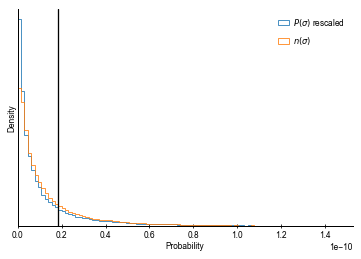

In [208]:
bins = np.linspace(0.0, np.percentile(nsigmas, 99), 100)
fig, ax = plt.subplots()
histkwargs = dict(bins=bins, histtype='step')
ax.hist(psigmas*k*(S-1), label='$P(\sigma)$ rescaled', **histkwargs)
ax.hist(nsigmas, label='$n(\sigma)$', **histkwargs)
ax.legend()
ax.axvline(1/S**k * k*(S-1), c='k')
ax.set_xlim(min(bins), max(bins))
ax.set_yticks([])
ax.set_ylabel('Density')
ax.set_xlabel('Probability');

## TODO

- Check these formulas!
- What about longer distances? (Second, third neighbours etc.?) Do things generalize?
- Test with rough Mount Fuji?